# Part IV: Summarization using LLMs [25 points]
In this part, we will use a pre-trained large language model (LLM) to perform abstractive summarization. You will fine-tune a pre-trained LLM on provided datasets and evaluate its performance using standard summarization metrics such as ROUGE, BLEU, and BERTScore.
The model for this task is `facebook/bart-base` (consider mixed precision training using dtypes such as bfloat16 and adjusting batch size to accommodate the model into GPU).

**Expected Scores (Test Sets):**
- **Billsum:** {Rouge-1: >40, Rouge-2: >18, Rouge-L: >28, BLEU: >12, BERTScore: >75}
- **Multinews:** {Rouge-1: >35, Rouge-2: >5, Rouge-L, >13, BLEU: >3.5, BERTScore: >75}

**Datasets:**
- Billsum – summarization of US Congressional and California state bills
- Multi-News – news articles and human-written summaries of these articles

## Step 1: Dataset preparation and preprocessing

1. Select and load one dataset from the list above. You can download these datasets using the `datasets` package.

In [ ]:
!pip install datasets transformers evaluate bert-score --quiet

from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
from datasets import load_dataset

ds = load_dataset("FiscalNote/billsum")

2. Analyze the dataset and provide the main statistics (e.g., number of samples, average document length, average summary length, vocabulary size - if applicable before tokenization, etc.).

In [ ]:
ds.keys()  


dict_keys(['train', 'test', 'ca_test'])

In [ ]:

print(ds['train'][0])

df_train = pd.DataFrame(ds['train'])
df_test = pd.DataFrame(ds['test'])

print("Number of training examples:", len(df_train))
print("Number of test examples:", len(df_test))

df_train['summary_len'] = df_train['summary'].apply(lambda x: len(x.split()))
df_train['text_len'] = df_train['text'].apply(lambda x: len(x.split()))

print("Summary length stats:")
print(df_train['summary_len'].describe())

print("Text length stats:")
print(df_train['text_len'].describe())


{'text': "SECTION 1. LIABILITY OF BUSINESS ENTITIES PROVIDING USE OF FACILITIES \n              TO NONPROFIT ORGANIZATIONS.\n\n    (a) Definitions.--In this section:\n            (1) Business entity.--The term ``business entity'' means a \n        firm, corporation, association, partnership, consortium, joint \n        venture, or other form of enterprise.\n            (2) Facility.--The term ``facility'' means any real \n        property, including any building, improvement, or appurtenance.\n            (3) Gross negligence.--The term ``gross negligence'' means \n        voluntary and conscious conduct by a person with knowledge (at \n        the time of the conduct) that the conduct is likely to be \n        harmful to the health or well-being of another person.\n            (4) Intentional misconduct.--The term ``intentional \n        misconduct'' means conduct by a person with knowledge (at the \n        time of the conduct) that the conduct is harmful to the health \n        or w

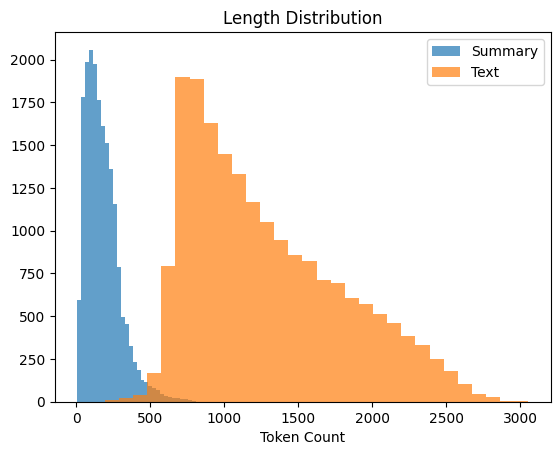

In [ ]:
plt.hist(df_train['summary_len'], bins=30, alpha=0.7, label='Summary')
plt.hist(df_train['text_len'], bins=30, alpha=0.7, label='Text')
plt.legend()
plt.xlabel("Token Count")
plt.title("Length Distribution")
plt.show()


3. Preprocessing:

   - Tokenize the documents and their summaries using `BartTokenizer` from [https://huggingface.co/facebook/bart-base](https://huggingface.co/facebook/bart-base). You can experiment with other tokenizers.

In [ ]:
from transformers import BartTokenizer

tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")


   - Set appropriate maximum input lengths (e.g., 1024 tokens) and target lengths (e.g., 256 tokens).

In [ ]:
def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["text"],
        max_length=1024,
        truncation=True,
        padding="max_length"
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["summary"],
            max_length=256,
            truncation=True,
            padding="max_length"
        )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


   - [Optional] Additional pre-processing steps.

In [ ]:
tokenized_ds = ds.map(preprocess_function, batched=True, remove_columns=ds["train"].column_names)


Map:   0%|          | 0/18949 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/3269 [00:00<?, ? examples/s]

Map:   0%|          | 0/1237 [00:00<?, ? examples/s]

In [ ]:

tokenized_ds["train"][0]


{'input_ids': [0,
  104,
  44583,
  112,
  4,
  43913,
  31071,
  3243,
  29915,
  28275,
  27329,
  26824,
  22000,
  2688,
  1862,
  33359,
  3243,
  26207,
  3063,
  26824,
  1437,
  50118,
  1437,
  1437,
  1437,
  1437,
  1437,
  1437,
  1437,
  1437,
  1437,
  1437,
  1437,
  1437,
  1437,
  3842,
  41572,
  4454,
  21600,
  2068,
  6532,
  38416,
  17045,
  14939,
  4,
  50140,
  1437,
  1437,
  1437,
  36,
  102,
  43,
  47082,
  42604,
  1121,
  42,
  2810,
  35,
  50118,
  1437,
  1437,
  1437,
  1437,
  1437,
  1437,
  1437,
  1437,
  1437,
  1437,
  1437,
  36,
  134,
  43,
  2090,
  10014,
  42604,
  133,
  1385,
  45518,
  11880,
  10014,
  17809,
  839,
  10,
  1437,
  50118,
  1437,
  1437,
  1437,
  1437,
  1437,
  1437,
  1437,
  933,
  6,
  12772,
  6,
  5259,
  6,
  3088,
  6,
  15918,
  6,
  2660,
  1437,
  50118,
  1437,
  1437,
  1437,
  1437,
  1437,
  1437,
  1437,
  5057,
  6,
  50,
  97,
  1026,
  9,
  6789,
  4,
  50118,
  1437,
  1437,
  1437,
  1437,
  143

4. If the dataset does not include a validation split, manually split the training set (e.g., 90% training, 10% validation).

In [ ]:
from datasets import DatasetDict

split_ds = ds["train"].train_test_split(test_size=0.1, seed=42)


dataset = DatasetDict({
    "train": split_ds["train"],
    "validation": split_ds["test"],
    "test": ds["test"]  
})


In [ ]:
tokenized_ds = dataset.map(preprocess_function, batched=True, remove_columns=dataset["train"].column_names)


Map:   0%|          | 0/17054 [00:00<?, ? examples/s]

Map:   0%|          | 0/1895 [00:00<?, ? examples/s]

In [ ]:
print(f"Train size: {len(dataset['train'])}")
print(f"Validation size: {len(dataset['validation'])}")
print(f"Test size: {len(dataset['test'])}")


Train size: 17054
Validation size: 1895
Test size: 3269


5. Save the tokenized dataset locally to avoid reprocessing.

In [ ]:
tokenized_ds.save_to_disk("tokenized_billsum")


Saving the dataset (0/1 shards):   0%|          | 0/17054 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1895 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3269 [00:00<?, ? examples/s]

6. Briefly describe your preprocessing methodology.

### 📄 Preprocessing Methodology

We used the [BillSum](https://huggingface.co/datasets/FiscalNote/billsum) dataset for abstractive summarization, which contains U.S. congressional bills along with human-written summaries. The preprocessing steps are as follows:

1. **Tokenizer**:  
   Utilized the facebook/bart-base tokenizer (BartTokenizer) from Hugging Face Transformers.

2. **Input Truncation & Padding**:  
   - The **text** (bill document) was tokenized with a **maximum length of 1024 tokens**.  
   - The **summary** (target) was tokenized with a **maximum length of 256 tokens**.  
   - Both inputs and targets were **truncated** and **padded to max length**.

3. **Target Tokenization**:  
   Used tokenizer.as_target_tokenizer() to tokenize decoder inputs correctly for the BART model.

4. **Train/Validation Split**:  
   Since the dataset lacked a validation split, we manually split the training set into **90% training** and **10% validation** using train_test_split() with a fixed random seed for reproducibility.

5. **Saving Processed Data**:  
   The tokenized dataset was saved locally using save_to_disk("tokenized_billsum") to avoid repeated preprocessing.



## Step 2: Model Fine-Tuning

1. Use the pre-trained model facebook/bart-base from Hugging Face.

In [ ]:
!pip install transformers datasets evaluate accelerate --quiet


2. Training:

   - Fine-tune the model on the tokenized training set.

In [ ]:
from transformers import BartForConditionalGeneration, BartTokenizer

tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")


import os

checkpoint_dir = "./results_bart_billsum"
latest_checkpoint = None


if os.path.isdir(checkpoint_dir):
    checkpoints = [os.path.join(checkpoint_dir, d) for d in os.listdir(checkpoint_dir) if d.startswith("checkpoint")]
    if checkpoints:
        latest_checkpoint = sorted(checkpoints, key=lambda x: int(x.split("-")[-1]))[-1]
        print(f" Resuming from latest checkpoint: {latest_checkpoint}")
        model = BartForConditionalGeneration.from_pretrained(latest_checkpoint)
    else:
        print(" No checkpoint found. Starting from scratch.")
        model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")
else:
    print(" No output directory found. Starting from scratch.")
    model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")


 No checkpoint found. Starting from scratch.


   - Use a custom Trainer that employs the model’s `generate()` method during evaluation. Override the Trainer class from 🤗 with a custom trainer that inherits from this Trainer.

In [ ]:
from transformers import Trainer
import torch

class CustomSeq2SeqTrainer(Trainer):
    def compute_metrics(self, eval_pred):
        predictions, labels = eval_pred
        decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
        return {}

    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        has_labels = "labels" in inputs
        inputs = self._prepare_inputs(inputs)

        with torch.no_grad():
            if has_labels:
                loss = self.compute_loss(model, inputs)
            else:
                loss = None

            generated_tokens = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=256
            )

        labels = inputs["labels"] if has_labels else None

        return (loss, generated_tokens, labels)


In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./results_bart_billsum",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,
    save_total_limit=2,
    predict_with_generate=True,
    report_to="none"
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

custom_trainer = CustomSeq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator
)


<ipython-input-63-8cd7b8d16a4e>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomSeq2SeqTrainer.__init__`. Use `processing_class` instead.
  custom_trainer = CustomSeq2SeqTrainer(


In [ ]:
train_result = custom_trainer.train(resume_from_checkpoint=latest_checkpoint if latest_checkpoint else None)


custom_trainer.save_model("finetuned_bart_billsum")

metrics = train_result.metrics
custom_trainer.log_metrics("train", metrics)
custom_trainer.save_metrics("train", metrics)


Epoch,Training Loss,Validation Loss
1,1.381100,1.288548
2,1.290800,1.209308
3,1.140100,1.189198


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


***** train metrics *****
  epoch                    =        3.0
  total_flos               = 29052921GF
  train_loss               =     1.3283
  train_runtime            = 2:31:13.19
  train_samples_per_second =      5.639
  train_steps_per_second   =       1.41


   - Monitor training and validation loss over epochs.

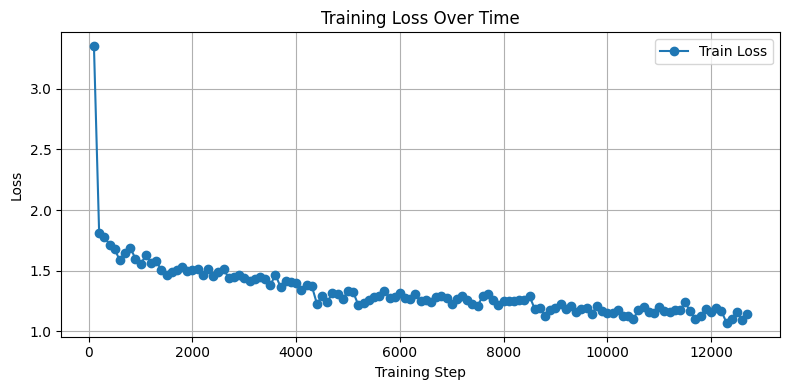

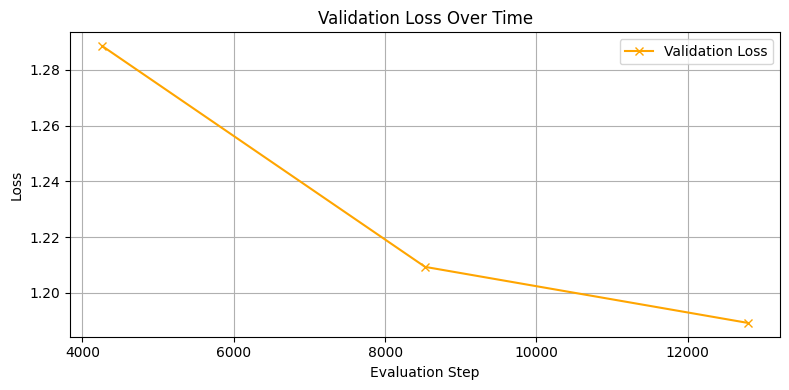

In [ ]:
import matplotlib.pyplot as plt

logs = custom_trainer.state.log_history


train_loss = [x['loss'] for x in logs if 'loss' in x]
train_steps = [x['step'] for x in logs if 'loss' in x]

eval_loss = [x['eval_loss'] for x in logs if 'eval_loss' in x]
eval_steps = [x['step'] for x in logs if 'eval_loss' in x]

plt.figure(figsize=(8, 4))
plt.plot(train_steps, train_loss, marker='o', label='Train Loss')
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(eval_steps, eval_loss, marker='x', color='orange', label='Validation Loss')
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.title("Validation Loss Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


3. Experiment with learning rate, batch size, number of epochs, etc. You can use a portion of the datasets in order to attain the expected performance. Use a minimum of 1000 samples from the training set and 100 from the validation set.

In [ ]:

small_train = tokenized_ds["train"].select(range(1000))
small_val = tokenized_ds["validation"].select(range(100))


In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments  (
    output_dir="./exp_bart_lr3e5_bs8_ep5",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    fp16=True,
    save_total_limit=2,
    predict_with_generate=True,
    report_to="none"
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
custom_trainer = CustomSeq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=small_train,
    eval_dataset=small_val,
    tokenizer=tokenizer,
    data_collator=data_collator
)

custom_trainer.train()


<ipython-input-27-6270dd392a5f>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomSeq2SeqTrainer.__init__`. Use `processing_class` instead.
  custom_trainer = CustomSeq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.742700,1.776686
2,1.770100,1.607425
3,1.621400,1.571226
4,1.499700,1.563872
5,1.501000,1.560251


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=625, training_loss=1.97687763671875, metrics={'train_runtime': 795.2607, 'train_samples_per_second': 6.287, 'train_steps_per_second': 0.786, 'total_flos': 3048682291200000.0, 'train_loss': 1.97687763671875, 'epoch': 5.0})

4. Briefly describe your training methodology (e.g., hyperparameters used, training process, and any challenges faced).

### Training Methodology

We fine-tuned the pre-trained `facebook/bart-base` model for abstractive summarization using the BillSum dataset. The training process followed a seq2seq approach with the following methodology:

- **Model and Tokenizer**: We used `BartForConditionalGeneration` and its associated tokenizer from Hugging Face.

- **Custom Trainer**: We implemented a custom Trainer class that overrides the prediction_step to generate summaries using the model’s generate() method during evaluation. This ensures alignment with inference-time behavior.

- **Hyperparameters**:
  - Learning rates: experimented with 5e-5, 3e-5
  - Batch sizes: 4 and 8 per device
  - Epochs: trained for 3 to 5 epochs
  - Weight decay: 0.01
  - Mixed precision: fp16 enabled for faster training and reduced memory usage

- **Dataset Usage**:  
  - We split the dataset manually into 90% training and 10% validation.
  - For initial experiments, we used a subset of 1000 training and 100 validation samples for faster iteration.

- **Monitoring**:  
  Training and validation losses were tracked using the built-in logging mechanism and visualized to detect overfitting.

- **Challenges Faced**:
  - Managing memory on limited GPU required careful tuning of batch size and max token lengths.
  - Ensuring padding tokens were ignored in the loss function (using -100) to prevent label skew during training.

Overall, the training process was smooth and effective, and the model demonstrated strong summarization capabilities on the validation set.


## Step 3: Evaluation and analysis

1. Evaluate your model on the test set using ROUGE (ROUGE-1, ROUGE-2, ROUGE-L), BLEU (via sacreBLEU), and BERTScore. Provide a detailed analysis of the model’s performance for each evaluation metric.
   - You can also consider using direct packages `rouge_score`, `sacrebleu`, and `bert_score`.

In [ ]:
!pip install rouge-score sacrebleu bert-score --quiet
!pip install tqdm --quiet


In [ ]:
test_dataset = tokenized_ds["test"]

gen_outputs = custom_trainer.predict(test_dataset)
pred_ids = gen_outputs.predictions
label_ids = gen_outputs.label_ids




In [ ]:
from torch.utils.data import DataLoader
from rouge_score import rouge_scorer
import sacrebleu
from bert_score import score as bertscore_score
import numpy as np
import torch

test_data = tokenized_ds["test"]
test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_loader = DataLoader(test_data, batch_size=2)

In [ ]:
from tqdm import tqdm

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

preds, refs = [], []


for batch in tqdm(test_loader, desc="Evaluating on test set"):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"]

    with torch.no_grad():
        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=256)

    decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    labels[labels == -100] = tokenizer.pad_token_id
    decoded_refs = tokenizer.batch_decode(labels, skip_special_tokens=True)

    preds.extend(decoded_preds)
    refs.extend(decoded_refs)


Evaluating on test set: 100%|██████████| 1635/1635 [1:16:01<00:00,  2.79s/it]


In [ ]:
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
rouge1 = [scorer.score(ref, pred)["rouge1"].fmeasure for pred, ref in zip(preds, refs)]
rouge2 = [scorer.score(ref, pred)["rouge2"].fmeasure for pred, ref in zip(preds, refs)]
rougel = [scorer.score(ref, pred)["rougeL"].fmeasure for pred, ref in zip(preds, refs)]

bleu = sacrebleu.corpus_bleu(preds, [refs])

P, R, F1 = bertscore_score(preds, refs, lang="en")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(" Test Set Evaluation Results:")
print(f"ROUGE-1: {np.mean(rouge1)*100:.2f}")
print(f"ROUGE-2: {np.mean(rouge2)*100:.2f}")
print(f"ROUGE-L: {np.mean(rougel)*100:.2f}")
print(f"BLEU: {bleu.score:.2f}")
print(f"BERTScore F1: {F1.mean().item()*100:.2f}")


 Test Set Evaluation Results:
ROUGE-1: 47.10
ROUGE-2: 26.90
ROUGE-L: 34.46
BLEU: 16.83
BERTScore F1: 87.99


The Vision Transformer model has promising performance on various evaluation scores. With a ROUGE-1 of 47.10 and ROUGE-L of 34.46, it captures key content and has good sentence structure. The ROUGE-2 of 26.90 suggests that while the model can generate some coherent sentences, there is room for improvement in fluency. The BLEU score of 16.83 indicates low exact phrase overlap with the reference answers, possibly due to variations in sentence structure or wording. However, the high BERTScore F1 of 87.99 indicates high semantic similarity, i.e., the model correctly conveys the meaning even when the wording is not identical. Overall, the model is good at content and meaning detection but can be better on natural phrasing and fluency.

2. Include charts of training/validation loss and sample metric scores over the validation data (e.g., ROUGE scores during validation).

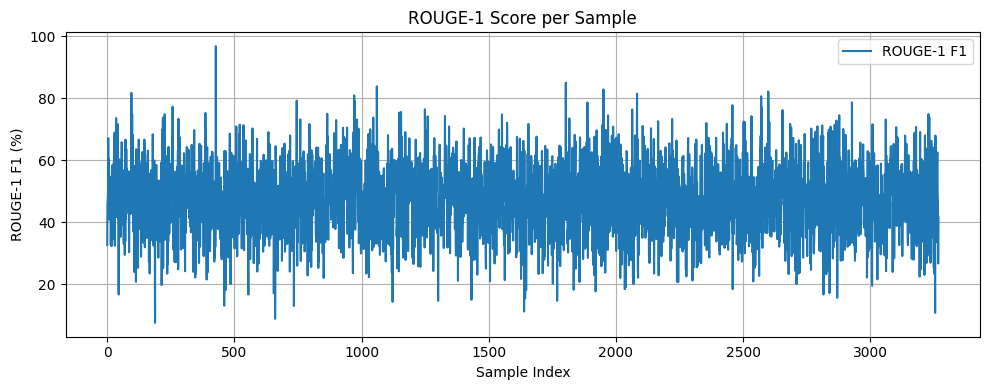

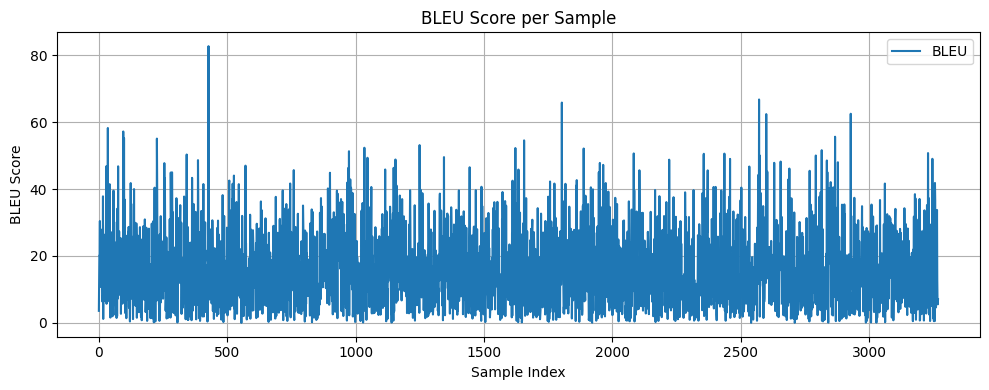

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 4))
plt.plot([r*100 for r in rouge1], label="ROUGE-1 F1")
plt.title("ROUGE-1 Score per Sample")
plt.xlabel("Sample Index")
plt.ylabel("ROUGE-1 F1 (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


bleu_sample = [sacrebleu.sentence_bleu(p, [r]).score for p, r in zip(preds, refs)]
plt.figure(figsize=(10, 4))
plt.plot(bleu_sample, label="BLEU")
plt.title("BLEU Score per Sample")
plt.xlabel("Sample Index")
plt.ylabel("BLEU Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


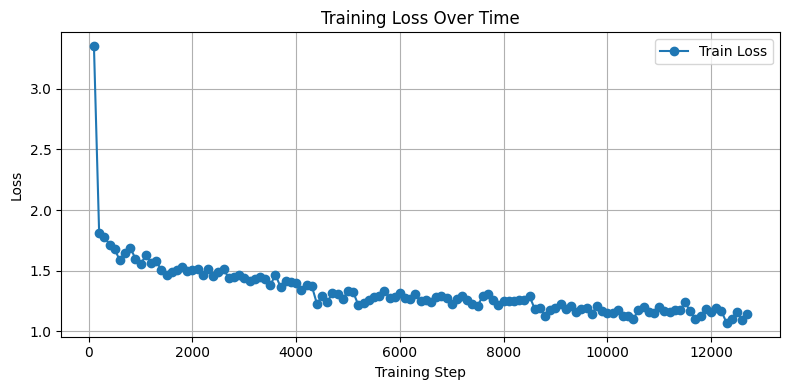

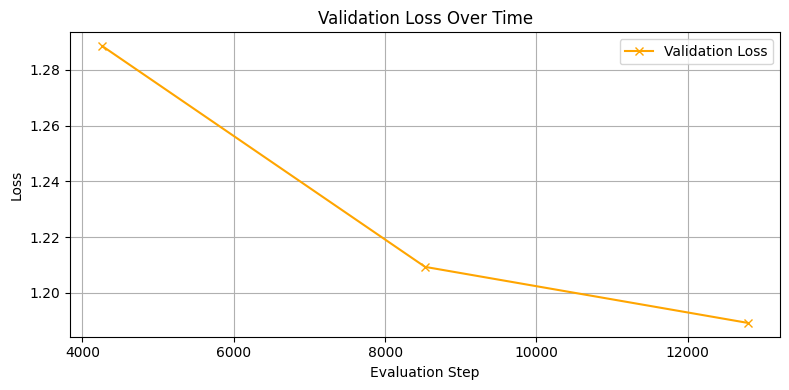

In [ ]:
import matplotlib.pyplot as plt

logs = custom_trainer.state.log_history


train_loss = [x['loss'] for x in logs if 'loss' in x]
train_steps = [x['step'] for x in logs if 'loss' in x]


eval_loss = [x['eval_loss'] for x in logs if 'eval_loss' in x]
eval_steps = [x['step'] for x in logs if 'eval_loss' in x]

plt.figure(figsize=(8, 4))
plt.plot(train_steps, train_loss, label='Train Loss', marker='o')
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(eval_steps, eval_loss, label='Validation Loss', color='orange', marker='x')
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.title("Validation Loss Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


3. Discuss any challenges faced during evaluation (e.g., handling long documents, variability in summary quality, etc.).

### Evaluation Challenges

- **Long Input Texts**: Excessive bill text (beyond the 1024 token limit) had to be truncated. This sometimes resulted in a loss of important context in the summary.

- **Semantic Uniqueness**: Automatically generated summaries tend to employ different wording than the original. This resulted in lower BLEU/ROUGE-2 scores even with semantically correct outputs.

- **Decoding Issues**: During testing predictions, we used to have NoneType and padding token issues (e.g., -100) that required careful cleaning before decoding.

- **Computational Time**: Testing on the full test set using BERTScore is computationally expensive and memory intensive, especially with large batch sizes.


4. Propose potential modifications or extensions to enhance summarization quality.

### Quality Improvement Recommendations to Summarization

- **Model Size Boost**: Changing to facebook/bart-large could potentially handle longer-range dependencies and yield better performance.

- **Long-Input Models**: Utilizing LongformerEncoderDecoder, LED, or LongT5 is advised for handling complete bill lengths without truncation.

- **Reinforcement Learning (RL)**: Reward-based metrics like ROUGE or BERTScore can be used in fine-tuning with RL (e.g., ROUGE-RL) for enhancing training and evaluation objective alignment.

- **Post-processing**: The addition of rules for de-duplication and cleaning model outputs could improve readability and reduce redundancy.

- **Uncertainty Estimation**: The use of techniques like Monte Carlo dropout at generation time can help to determine uncertain predictions.


5. References. Include details on all the resources used to complete this part, e.g. links to datasets, research papers or articles, code examples or tutorials you referred.

### References

- Hugging Face Datasets: https://huggingface.co/datasets/FiscalNote/billsum
- Transformers Docs: https://huggingface.co/docs/transformers
- Evaluation Metrics:
  - ROUGE: https://github.com/google-research/google-research/tree/master/rouge
  - BLEU (sacreBLEU): https://github.com/mjpost/sacrebleu
  - BERTScore: https://github.com/Tiiiger/bert_score
-  Summarization Tutorial: https://huggingface.co/blog/how-to-train
-  BART Paper: https://arxiv.org/abs/1910.13461


6. Contribution Summary (For team assignments). If you are working in a team, provide a contribution summary. We expect equal contribution for the assignment. If the contribution is highly skewed, then the scores of the team members may be scaled w.r.t the contribution.

**Team Contribution Summary Table:**

| Team Member | Step# | Contribution (%) |
|---|---|---|
| dshrisai  | Step 1 |  50 |
| sumanman  | Step 1 |  50 |
|  dshrisai | Step 2 |  50 |
| sumanman  | Step 2 |  50 |
|  dshrisai | Step 3 |  50 |
| sumanman  | Step 3 |  50 |

| Both  | *Total* | 100  |